<a href="https://colab.research.google.com/github/Mohammad-H-Zahrawi/Challenges-Kaggle/blob/main/Banking%20Dataset%20Analysis%20and%20Classification/bank_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libiaries and data

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, make_scorer, recall_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
pd.options.mode.chained_assignment = None
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV,  RandomizedSearchCV
from sklearn import svm
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
train = pd.read_csv("/content/Train-Set.csv")
test = pd.read_csv("/content/Test-Set.csv")
test_ids = test['id']

## preprocessing

In [ ]:
cols_to_category = [ "job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]
train[cols_to_category] = train[cols_to_category].astype("category")
months = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
days = ["mon", "tue", "wed", "thu", "fri", "sat", "sun"]

#handling month_and day columns
def fix_swapped_values(row):
    day = row['day']
    month = row['month']
    if day in months and month in days:
        row['day'], row['month'] = row['month'], row['day']
    return row

def update_days(data, day_name, new_days):
    day_rows = data[data['day'] == day_name]
    day_sets = np.array_split(day_rows, len(new_days))
    for i, subset in enumerate(day_sets):
        subset['day'] = new_days[i]
        data.update(subset)
    return data

days_mapping = {
    'mon': ['5', '12', '19', '26'],
    'thu': ['8', '15', '22', '29'],
    'wed': ['7', '14', '21', '28'],
    'fri': ['8', '15', '22', '29'],
    'tue': ['6', '13', '20', '27']}

def process_data(data):
    for day, new_days in days_mapping.items():
        data = update_days(data, day, new_days)
    return data

train = process_data(train)
test = process_data(test)

# Apply the function to each row
train= train.apply(fix_swapped_values, axis=1)
test= test.apply(fix_swapped_values, axis=1)

In [ ]:
Q1 = train['age'].quantile(q=0.25)
Q2 = train['age'].quantile(q=0.50)
Q3 = train['age'].quantile(q=0.75)
Q4 = train['age'].quantile(q=1.00)
print('1st Quartile (Q1): ', Q1)
print('2nd Quartile (Median, Q2): ', Q2)
print('3rd Quartile (Q3): ', Q3)
print('4th Quartile (Max, Q4): ', Q4)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1
# Calculate the lower and upper bounds for detecting outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print('Lower bound for outliers: ', lower_bound)
print('Upper bound for outliers: ', upper_bound)
train['age'] = train['age'].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)

#handling age
Q1 = test['age'].quantile(q=0.25)
Q2 = test['age'].quantile(q=0.50)
Q3 = test['age'].quantile(q=0.75)
Q4 = test['age'].quantile(q=1.00)
print('1st Quartile (Q1): ', Q1)
print('2nd Quartile (Median, Q2): ', Q2)
print('3rd Quartile (Q3): ', Q3)
print('4th Quartile (Max, Q4): ', Q4)
# Calculate the interquartile range (IQR)
IQR = Q3 - Q1
# Calculate the lower and upper bounds for detecting outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print('Lower bound for outliers: ', lower_bound)
print('Upper bound for outliers: ', upper_bound)
# Replace outliers with the bounds or another value (e.g., median)
test['age'] = test['age'].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)


1st Quartile (Q1):  32.0
2nd Quartile (Median, Q2):  39.0
3rd Quartile (Q3):  48.0
4th Quartile (Max, Q4):  98.0
Lower bound for outliers:  8.0
Upper bound for outliers:  72.0
1st Quartile (Q1):  32.0
2nd Quartile (Median, Q2):  39.0
3rd Quartile (Q3):  48.0
4th Quartile (Max, Q4):  94.0
Lower bound for outliers:  8.0
Upper bound for outliers:  72.0


In [ ]:
cols_to_category = [ "job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]
train[cols_to_category] = train[cols_to_category].astype("category")
train["Target"] = train['Target'].map({'no':0, 'yes':1})
columns_extra = ['id' , 'Unnamed: 0']

#labeling education column
train["education"] = train["education"].replace({'unknown':0,'illiterate':0,'primary':1,'basic.4y':1,'basic.6y':1,'basic.9y':1,'secondary':2,'high.school':2,'professional.course':2,'tertiary':3,'university.degree':3})
test["education"] = test["education"].replace({'unknown':0,'illiterate':0,'primary':1,'basic.4y':1,'basic.6y':1,'basic.9y':1,'secondary':2,'high.school':2,'professional.course':2,'tertiary':3,'university.degree':3})
train["education"] = train["education"].astype(int)
test["education"] = test["education"].astype(int)

#fixing unknown in education
train.loc[(train.education == "unknown") & (train.job == "admin."),"education"] = train.loc[(train.education == "unknown") & (train.job == "admin."),"education"].apply(lambda x: 'university.degree')
train.loc[(train.education == "unknown") & (train.job == "management"),"education"] = train.loc[(train.education == "unknown") & (train.job == "management"),"education"].apply(lambda x: 'tertiary')
train.loc[(train.education == "unknown") & (train.job == "services"),"education"] = train.loc[(train.education == "unknown") & (train.job == "services"),"education"].apply(lambda x: 'secondary')
train.loc[(train.education == "unknown") & (train.job == "technician."),"education"] = train.loc[(train.education == "unknown") & (train.job == "technician."),"education"].apply(lambda x: 'secondary')
train.loc[(train.education == "unknown") & (train.job == "retired"),"education"] = train.loc[(train.education == "unknown") & (train.job == "retired"),"education"].apply(lambda x: 'secondary')
train.loc[(train.education == "unknown") & (train.job == "blue-collar"),"education"] = train.loc[(train.education == "unknown") & (train.job == "blue-collar"),"education"].apply(lambda x: 'secondary')
train.loc[(train.education == "unknown") & (train.job == "housemaid."),"education"] = train.loc[(train.education == "unknown") & (train.job == "housemaid."),"education"].apply(lambda x: 'primary')
train.loc[(train.education == "unknown") & (train.job == "self-employed"),"education"] = train.loc[(train.education == "unknown") & (train.job == "self-employed"),"education"].apply(lambda x: 'tertiary')
train.loc[(train.education == "unknown") & (train.job == "student"),"education"] = train.loc[(train.education == "unknown") & (train.job == "student"),"education"].apply(lambda x: 'secondary')
train.loc[(train.education == "unknown") & (train.job == "entrepreneur"),"education"] = train.loc[(train.education == "unknown") & (train.job == "entrepreneur"),"education"].apply(lambda x: 'tertiary')
train.loc[(train.education == "unknown") & (train.job == "unemployed"),"education"] = train.loc[(train.education == "unknown") & (train.job == "unemployed"),"education"].apply(lambda x: 'secondary')
train.loc[(train.education == "unknown"),"education"] = train.loc[(train.education == "unknown"),"education"].apply(lambda x: 'secondary')

test.loc[(test.education == "unknown") & (test.job == "admin."),"education"] = test.loc[(test.education == "unknown") & (test.job == "admin."),"education"].apply(lambda x: 'university.degree')
test.loc[(test.education == "unknown") & (test.job == "management"),"education"] = test.loc[(test.education == "unknown") & (test.job == "management"),"education"].apply(lambda x: 'tertiary')
test.loc[(test.education == "unknown") & (test.job == "services"),"education"] = test.loc[(test.education == "unknown") & (test.job == "services"),"education"].apply(lambda x: 'secondary')
test.loc[(test.education == "unknown") & (test.job == "technician."),"education"] = test.loc[(test.education == "unknown") & (test.job == "technician."),"education"].apply(lambda x: 'secondary')
test.loc[(test.education == "unknown") & (test.job == "retired"),"education"] = test.loc[(test.education == "unknown") & (test.job == "retired"),"education"].apply(lambda x: 'secondary')
test.loc[(test.education == "unknown") & (test.job == "blue-collar"),"education"] = test.loc[(test.education == "unknown") & (test.job == "blue-collar"),"education"].apply(lambda x: 'secondary')
test.loc[(test.education == "unknown") & (test.job == "housemaid."),"education"] = test.loc[(test.education == "unknown") & (test.job == "housemaid."),"education"].apply(lambda x: 'primary')
test.loc[(test.education == "unknown") & (test.job == "self-employed"),"education"] = test.loc[(test.education == "unknown") & (test.job == "self-employed"),"education"].apply(lambda x: 'tertiary')
test.loc[(test.education == "unknown") & (test.job == "student"),"education"] = test.loc[(test.education == "unknown") & (test.job == "student"),"education"].apply(lambda x: 'secondary')
test.loc[(test.education == "unknown") & (test.job == "entrepreneur"),"education"] = test.loc[(test.education == "unknown") & (test.job == "entrepreneur"),"education"].apply(lambda x: 'tertiary')
test.loc[(test.education == "unknown") & (test.job == "unemployed"),"education"] = test.loc[(test.education == "unknown") & (test.job == "unemployed"),"education"].apply(lambda x: 'secondary')
test.loc[(test.education == "unknown"),"education"] = test.loc[(test.education == "unknown"),"education"].apply(lambda x: 'secondary')

#fixing unknown in job
train.loc[(train.job == "unknown") & (train.education == "basic.4y"),"job"] = train.loc[(train.job == "unknown") & (train.education == "basic.4y"),"job"].apply(lambda x: 'blue-collar')
train.loc[(train.job == "unknown") & (train.education == "basic.9y"),"job"] = train.loc[(train.job == "unknown") & (train.education == "basic.9y"),"job"].apply(lambda x: 'blue-collar')
train.loc[(train.job == "unknown") & (train.education == "basic.6y"),"job"] = train.loc[(train.job == "unknown") & (train.education == "basic.6y"),"job"].apply(lambda x: 'blue-collar')
train.loc[(train.job == "unknown") & (train.education == "tertiary"),"job"] = train.loc[(train.job == "unknown") & (train.education == "tertiary"),"job"].apply(lambda x: 'admin.')
train.loc[(train.job == "unknown") & (train.education == "primary"),"job"] = train.loc[(train.job == "unknown") & (train.education == "primary"),"job"].apply(lambda x: 'management')
train.loc[(train.job == "unknown") & (train.education == "high.school"),"job"] = train.loc[(train.job == "unknown") & (train.education == "high.school"),"job"].apply(lambda x: 'admin.')
train.loc[(train.job == "unknown") & (train.education == "university.degree"),"job"] = train.loc[(train.job == "unknown") & (train.education == "university.degree"),"job"].apply(lambda x: 'admin.')
train.loc[(train.job == "unknown") & (train.education == "professional.course"),"job"] = train.loc[(train.job == "unknown") & (train.education == "professional.course"),"job"].apply(lambda x: 'technician')
train.loc[(train.job == "unknown") & (train.education == "illiterate"),"job"] = train.loc[(train.job == "unknown") & (train.education == "illiterate"),"job"].apply(lambda x: 'blue-collar')
train.loc[(train.job == "unknown") & (train.education == "secondary"),"job"] = train.loc[(train.job == "unknown") & (train.education == "secondary"),"job"].apply(lambda x: 'blue-collar')
train.loc[(train.job == "unknown"),"job"] = train.loc[(train.job == "unknown"),"job"].apply(lambda x: 'blue-collar')

test.loc[(test.job == "unknown") & (test.education == "basic.4y"),"job"] = test.loc[(test.job == "unknown") & (test.education == "basic.4y"),"job"].apply(lambda x: 'blue-collar')
test.loc[(test.job == "unknown") & (test.education == "basic.9y"),"job"] = test.loc[(test.job == "unknown") & (test.education == "basic.9y"),"job"].apply(lambda x: 'blue-collar')
test.loc[(test.job == "unknown") & (test.education == "basic.6y"),"job"] = test.loc[(test.job == "unknown") & (test.education == "basic.6y"),"job"].apply(lambda x: 'blue-collar')
test.loc[(test.job == "unknown") & (test.education == "tertiary"),"job"] = test.loc[(test.job == "unknown") & (test.education == "tertiary"),"job"].apply(lambda x: 'management')
test.loc[(test.job == "unknown") & (test.education == "primary"),"job"] = test.loc[(test.job == "unknown") & (test.education == "primary"),"job"].apply(lambda x: 'blue-collar')
test.loc[(test.job == "unknown") & (test.education == "high.school"),"job"] = test.loc[(test.job == "unknown") & (test.education == "high.school"),"job"].apply(lambda x: 'admin.')
test.loc[(test.job == "unknown") & (test.education == "university.degree"),"job"] = test.loc[(test.job == "unknown") & (test.education == "university.degree"),"job"].apply(lambda x: 'admin.')
test.loc[(test.job == "unknown") & (test.education == "professional.course"),"job"] = test.loc[(test.job == "unknown") & (test.education == "professional.course"),"job"].apply(lambda x: 'technician')
test.loc[(test.job == "unknown") & (test.education == "illiterate"),"job"] = test.loc[(test.job == "unknown") & (test.education == "illiterate"),"job"].apply(lambda x: 'blue-collar')
test.loc[(test.job == "unknown") & (test.education == "secondary"),"job"] = test.loc[(test.job == "unknown") & (test.education == "secondary"),"job"].apply(lambda x: 'blue-collar')
test.loc[(test.job == "unknown"),"job"] = test.loc[(test.job == "unknown"),"job"].apply(lambda x: 'blue-collar')

train['housing'] = train['housing'].replace({'unknown':'no'})
test['housing'] = test['housing'].replace({'unknown':'no'})
train['poutcome'] = train['poutcome'].replace({'nonexistent':'unknown'})
test['poutcome'] = test['poutcome'].replace({'nonexistent':'unknown'})

missing_balance=train.groupby(['job', 'education'])['balance'].median()
missing_balance = missing_balance.fillna(449.0)

In [ ]:
#filling balance column
for i, j in enumerate(train['balance'].values):
    if np.isnan(j):
        train.loc[i, 'balance'] = missing_balance[train['job'][i]][train['education'][i]]

for i, j in enumerate(test['balance'].values):
    if np.isnan(j):
        test.loc[i, 'balance'] = missing_balance[train['job'][i]][train['education'][i]]

train['day'] = train['day'].astype('category')
test['day'] = test['day'].astype('category')

columns_categories = list(train.select_dtypes(include="category").columns.values)
train = pd.get_dummies( train, prefix=columns_categories, columns=columns_categories, drop_first=True)
test = pd.get_dummies( test, prefix=columns_categories, columns=columns_categories, drop_first=True)

X = train.drop('Target', axis=1)
y = train["Target"]

## using oversampling by BorderLineSMOTE

In [ ]:
# four ways to solve imbalanced data

# rus = RandomUnderSampler(random_state=42)
# X, y = rus.fit_resample(X, y)

# from imblearn.over_sampling import RandomOverSampler
# oversample = RandomOverSampler(sampling_strategy='auto')
# X, y = oversample.fit_resample(X, y)

# from imblearn.over_sampling import SMOTE
# from collections import Counter
# # Assume X, y are the features and labels
# smote = SMOTE(sampling_strategy='auto', random_state=42)
# X, y  = smote.fit_resample(X, y)

from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter
borderline_smote = BorderlineSMOTE(sampling_strategy='auto')
X, y  = borderline_smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 , random_state=66)
rs = make_scorer(recall_score)

In [ ]:
X['campaign'] = np.log1p(X['campaign'])
test['campaign'] = np.log1p(test['campaign'])

X['previous'] = np.log1p(X['previous'])
test['previous'] = np.log1p(test['previous'])

# Modeling

### Logistic

In [ ]:
#logistic Regression

from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()

cv = cross_val_score(lg, X_train, y_train, cv=10, n_jobs=-1, scoring=rs)
print("Cross validation scores: {}".format(cv))
print("%0.2f recall with a standard deviation of %0.2f" % (cv.mean(), cv.std()))
lg.fit(X_train, y_train)

#change the name of model
print('model', lg)
pred_train = lg.predict(X_train)
print("The train recall score is {}".format(np.round(recall_score(y_train, pred_train),   4)))
train_accuracy = accuracy_score(y_train, pred_train)
train_f1_score = f1_score(y_train, pred_train)
print("The train accuracy is {}".format(np.round(train_accuracy, 4)))
print("The train f1 is {}".format(np.round(train_f1_score, 4)))
pred_test = lg.predict(X_test)
print("The test recall is {}".format(np.round(recall_score(y_test, pred_test), 4)))
test_accuracy = accuracy_score(y_test, pred_test)
test_f1_score = f1_score(y_test, pred_test)
print("The test accuracy is {}".format(np.round(test_accuracy, 4)))
print("The test f1 is {}".format(np.round(test_f1_score, 4)))
print(' ')


Cross validation scores: [0.81196328 0.78679301 0.80900207 0.80722535 0.80989044 0.79863784
 0.80663311 0.81403613 0.80544862 0.79330767]
0.80 recall with a standard deviation of 0.01


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


model LogisticRegression()
The train recall score is 0.7998
The train accuracy is 0.7917
The train f1 is 0.7927
The test recall is 0.7967
The test accuracy is 0.7892
The test f1 is 0.7923
 


### HGBC

In [ ]:
#hgbc
hgbc = HistGradientBoostingClassifier(max_iter=100)

cv = cross_val_score(hgbc, X_train, y_train, cv=10, n_jobs=-1, scoring=rs)
print("Cross validation scores: {}".format(cv))
print("%0.2f recall with a standard deviation of %0.2f" % (cv.mean(), cv.std()))
hgbc.fit(X_train, y_train)

#change the name of model
print('model', hgbc)
pred_train = hgbc.predict(X_train)
print("The train recall score is {}".format(np.round(recall_score(y_train, pred_train),   4)))
train_accuracy = accuracy_score(y_train, pred_train)
train_f1_score = f1_score(y_train, pred_train)
print("The train accuracy is {}".format(np.round(train_accuracy, 4)))
print("The train f1 is {}".format(np.round(train_f1_score, 4)))
pred_test = hgbc.predict(X_test)
print("The test recall is {}".format(np.round(recall_score(y_test, pred_test), 4)))
test_accuracy = accuracy_score(y_test, pred_test)
test_f1_score = f1_score(y_test, pred_test)
print("The test accuracy is {}".format(np.round(test_accuracy, 4)))
print("The test f1 is {}".format(np.round(test_f1_score, 4)))
print(' ')

Cross validation scores: [0.94580989 0.94018359 0.93751851 0.94462541 0.94906722 0.93722239
 0.94995558 0.94610601 0.94492153 0.94047972]
0.94 recall with a standard deviation of 0.00
model HistGradientBoostingClassifier()
The train recall score is 0.9486
The train accuracy is 0.9463
The train f1 is 0.9462
The test recall is 0.9457
The test accuracy is 0.9404
The test f1 is 0.9412
 


### xgboost

In [ ]:
import xgboost as xgb

In [ ]:
X_train['day']=X_train['day'].astype('float')
X_test['day']=X_test['day'].astype('float')

In [ ]:
#without__Unnamed
xgb_clf = XGBClassifier( eval_metric='logloss', random_state=42 , colsample_bytree=0.7415221452340588,
                gamma =0.16057649218989223, learning_rate=0.16, max_depth=18, min_child_weight=6,
            n_estimators=300, reg_alpha=45 , reg_lambda=0.2518190183275437, subsample=0.99762069338396)

cv = cross_val_score(xgb_clf, X_train, y_train, cv=10, n_jobs=-1, scoring=rs)
print("Cross validation scores: {}".format(cv))
print("%0.2f recall with a standard deviation of %0.2f" % (cv.mean(), cv.std()))
xgb_clf.fit(X_train, y_train)

#change the name of model
print('model', xgb_clf)
pred_train = xgb_clf.predict(X_train)
print("The train recall score is {}".format(np.round(recall_score(y_train, pred_train),   4)))
train_accuracy = accuracy_score(y_train, pred_train)
train_f1_score = f1_score(y_train, pred_train)
print("The train accuracy is {}".format(np.round(train_accuracy, 4)))
print("The train f1 is {}".format(np.round(train_f1_score, 4)))
pred_test = xgb_clf.predict(X_test)
print("The test recall is {}".format(np.round(recall_score(y_test, pred_test), 4)))
test_accuracy = accuracy_score(y_test, pred_test)
test_f1_score = f1_score(y_test, pred_test)
print("The test accuracy is {}".format(np.round(test_accuracy, 4)))
print("The test f1 is {}".format(np.round(test_f1_score, 4)))
print(' ')

Cross validation scores: [0.94344092 0.9416642  0.93751851 0.94344092 0.94788274 0.93959135
 0.94669825 0.94758662 0.94432929 0.94107196]
0.94 recall with a standard deviation of 0.00
model XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7415221452340588, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.16057649218989223, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.16, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
The train re

### Random Forest

In [ ]:
rfc_model = RandomForestClassifier(n_jobs=-1, random_state=42, class_weight="balanced_subsample")

cv = cross_val_score(rfc_model, X_train, y_train, cv=10, n_jobs=-1, scoring=rs)
print("Cross validation scores: {}".format(cv))
print("%0.2f recall with a standard deviation of %0.2f" % (cv.mean(), cv.std()))
rfc_model.fit(X_train, y_train)

#change the name of model
print('model', rfc_model)
pred_train = rfc_model.predict(X_train)
print("The train recall score is {}".format(np.round(recall_score(y_train, pred_train),   4)))
train_accuracy = accuracy_score(y_train, pred_train)
train_f1_score = f1_score(y_train, pred_train)
print("The train accuracy is {}".format(np.round(train_accuracy, 4)))
print("The train f1 is {}".format(np.round(train_f1_score, 4)))
pred_test = rfc_model.predict(X_test)
print("The test recall is {}".format(np.round(recall_score(y_test, pred_test), 4)))
test_accuracy = accuracy_score(y_test, pred_test)
test_f1_score = f1_score(y_test, pred_test)
print("The test accuracy is {}".format(np.round(test_accuracy, 4)))
print("The test f1 is {}".format(np.round(test_f1_score, 4)))
print(' ')

Cross validation scores: [0.95676636 0.95380515 0.94729049 0.95647024 0.95824696 0.95202843
 0.95528576 0.95321291 0.95291679 0.94758662]
0.95 recall with a standard deviation of 0.00
model RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1,
                       random_state=42)
The train recall score is 1.0
The train accuracy is 1.0
The train f1 is 1.0
The test recall is 0.9572
The test accuracy is 0.9465
The test f1 is 0.9475
 


### CatBoost

In [ ]:
rs = make_scorer(recall_score)

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.9 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, KFold
from catboost import CatBoostClassifier, Pool
catBoost = CatBoostClassifier(iterations=150, depth=8, learning_rate=0.1,
                           loss_function='Logloss', custom_metric=['F1'], random_seed=42)


In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = []
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    model_clone = catBoost.copy()  # Create a copy of the model for each fold
    model_clone.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold))  # Use eval_set for custom metrics during training

    y_pred_fold = model_clone.predict(X_val_fold)
    cv_scores.append(recall_score(y_val_fold, y_pred_fold))


In [ ]:
catBoost.fit(X_train, y_train)
# train_pool = Pool(X_train, y_train)
# eval_pool = Pool(X_test, y_test)
# catBoost.fit(train_pool, eval_set=eval_pool)
# catBoost.fit(X,y, plot=True)

0:	learn: 0.3679363	total: 106ms	remaining: 15.7s
1:	learn: 0.2018801	total: 200ms	remaining: 14.8s
2:	learn: 0.1022402	total: 286ms	remaining: 14s
3:	learn: 0.0575975	total: 367ms	remaining: 13.4s
4:	learn: 0.0343157	total: 459ms	remaining: 13.3s
5:	learn: 0.0196299	total: 538ms	remaining: 12.9s
6:	learn: 0.0114257	total: 587ms	remaining: 12s
7:	learn: 0.0073136	total: 659ms	remaining: 11.7s
8:	learn: 0.0049253	total: 741ms	remaining: 11.6s
9:	learn: 0.0031337	total: 785ms	remaining: 11s
10:	learn: 0.0023215	total: 836ms	remaining: 10.6s
11:	learn: 0.0015931	total: 881ms	remaining: 10.1s
12:	learn: 0.0011978	total: 954ms	remaining: 10.1s
13:	learn: 0.0009433	total: 1.03s	remaining: 10s
14:	learn: 0.0007592	total: 1.11s	remaining: 9.96s
15:	learn: 0.0006317	total: 1.14s	remaining: 9.54s
16:	learn: 0.0005405	total: 1.19s	remaining: 9.29s
17:	learn: 0.0004709	total: 1.25s	remaining: 9.14s
18:	learn: 0.0003926	total: 1.27s	remaining: 8.77s
19:	learn: 0.0003401	total: 1.34s	remaining: 8.71

In [ ]:
#change the name of model
print('model', catBoost)
pred_train = catBoost.predict(X_train)
print("The train recall score is {}".format(np.round(recall_score(y_train, pred_train),   4)))
train_accuracy = accuracy_score(y_train, pred_train)
train_f1_score = f1_score(y_train, pred_train)
print("The train accuracy is {}".format(np.round(train_accuracy, 4)))
print("The train f1 is {}".format(np.round(train_f1_score, 4)))
pred_test = catBoost.predict(X_test)
print("The test recall is {}".format(np.round(recall_score(y_test, pred_test), 4)))
test_accuracy = accuracy_score(y_test, pred_test)
test_f1_score = f1_score(y_test, pred_test)
print("The test accuracy is {}".format(np.round(test_accuracy, 4)))
print("The test f1 is {}".format(np.round(test_f1_score, 4)))
print(' ')

model <catboost.core.CatBoostClassifier object at 0x7ea3bba27640>
The train recall score is 1.0
The train accuracy is 1.0
The train f1 is 1.0
The test recall is 1.0
The test accuracy is 1.0
The test f1 is 1.0
 


In [ ]:
train_error = model.get_evals_result()['learn']['Logloss']
test_error = model.get_evals_result()['validation']['Logloss']

# Plot the training and test errors
plt.figure(figsize=(10, 6))
plt.plot(train_error, label='Train Error')
plt.plot(test_error, label='Test Error')
plt.xlabel('Iterations')
plt.ylabel('Logloss')
plt.title('Training and Test Error over Iterations')
plt.legend()
plt.show()

#### grid search catboost

In [ ]:
model = CatBoostClassifier(eval_metric='F1', random_seed=42, verbose=False)

# Define the grid of hyperparameters
param_grid = {
    'iterations': [100, 200, 300, 500],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1 , 0.2],
    'l2_leaf_reg': [3, 5, 7],
    'bagging_temperature': [0, 0.5, 1]
}

# Define the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Print the accuracy of each model evaluated during grid search

results = grid_search.cv_results_
for i, params in enumerate(results['params']):
    mean_score = results['mean_test_score'][i]
    std_score = results['std_test_score'][i]
    print(f"Params: {params} --> Mean Test F1 Score: {mean_score:.4f} (Std Test F1 Score: {std_score:.4f})")

### Stacking

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import StackingClassifier

In [ ]:
level_0_classifiers = dict()
level_0_classifiers["HGBC"] = HistGradientBoostingClassifier(random_state=42)
level_0_classifiers["forest"] = RandomForestClassifier(random_state=42)
level_0_classifiers["xgboost"] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
level_0_classifiers["xtrees"] = ExtraTreesClassifier(random_state=42)
level_1_classifier = ExtraTreesClassifier(random_state=42)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stacking_model = StackingClassifier(estimators=list(level_0_classifiers.items()), final_estimator=level_1_classifier, passthrough=True, cv=kfold, stack_method="predict_proba")
level_0_columns = [f"{name}_prediction" for name in level_0_classifiers.keys()]

stacking_model.fit(X_train, y_train)

# pd.DataFrame(stacking_model.fit_transform(X_train, y_train), columns=level_0_columns + list(X_train.columns))
import copy as cp # Import the copy module and alias it as 'cp'


df_explain_sklearn = pd.DataFrame()

for name, classifier in level_0_classifiers.items():
    classifier_ = cp.deepcopy(classifier)
    classifier_.fit(X_train, y_train)
    y_predict_proba = classifier_.predict_proba(X_train)[:, 1]
    df_explain_sklearn = pd.concat([df_explain_sklearn, pd.DataFrame(y_predict_proba, columns=[f"{name}_prediction"])], axis=1)

In [ ]:
stacking_model

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('HGBC',
                                HistGradientBoostingClassifier(random_state=42)),
                               ('forest',
                                RandomForestClassifier(random_state=42)),
                               ('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              ear...
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('xtrees',
                                ExtraTreesClassifier(random_state=42))],
                   final_estimator=ExtraTreesClassifier(random_state=42),
                   passthrough=True, stack_method='predict_proba')

In [ ]:
y_val_pred = stacking_model.predict(X_test)
y_val_pred

print(f"Accuracy of scikit-learn stacking classifier: {accuracy_score(y_test, y_val_pred)}")

print(f"F1 score of scikit-learn stacking classifier: {f1_score(y_test, y_val_pred)}")

for name, classifier in level_0_classifiers.items():
    classifier_ = cp.deepcopy(classifier)
    classifier_.fit(X_train, y_train)

    print(f"f1 score of standalone {name} classifier: {f1_score(y_test, classifier_.predict(X_test))}")

Accuracy of scikit-learn stacking classifier: 0.9517205781142464
F1 score of scikit-learn stacking classifier: 0.9518811949103132
f1 score of standalone HGBC classifier: 0.9418746608790015
f1 score of standalone forest classifier: 0.9493735013002804
f1 score of standalone xgboost classifier: 0.9476237657589941
f1 score of standalone xtrees classifier: 0.9482134858560453


In [ ]:
model = stacking_model
print('model', model)
pred_train = model.predict(X_train)
print("The train recall score is {}".format(np.round(recall_score(y_train, pred_train),   4)))
train_accuracy = accuracy_score(y_train, pred_train)
train_f1_score = f1_score(y_train, pred_train)
print("The train accuracy is {}".format(np.round(train_accuracy, 4)))
print("The train f1 is {}".format(np.round(train_f1_score, 4)))
pred_test = model.predict(X_test)
print("The test recall is {}".format(np.round(recall_score(y_test, pred_test), 4)))
test_accuracy = accuracy_score(y_test, pred_test)
test_f1_score = f1_score(y_test, pred_test)
print("The test accuracy is {}".format(np.round(test_accuracy, 4)))
print("The test f1 is {}".format(np.round(test_f1_score, 4)))
print(' ')

model StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('HGBC',
                                HistGradientBoostingClassifier(random_state=42)),
                               ('forest',
                                RandomForestClassifier(random_state=42)),
                               ('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              ear...
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                          

# Feature Importance

In [ ]:
train.drop('balance', axis=1,inplace=True)
test.drop('balance', axis=1,inplace=True)

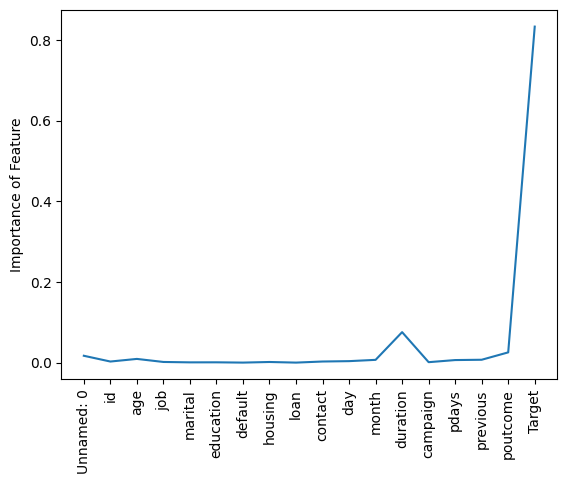

In [ ]:
from sklearn.ensemble import RandomForestClassifier
X = train.copy()

y = train.Target
x = X.drop('Target', axis=1)


x = x.fillna(-999)


for c in train.columns[train.dtypes == 'object']:
    X[c] = X[c].factorize()[0]

rf = RandomForestClassifier()
rf.fit(X,y)

plt.plot(rf.feature_importances_)
plt.ylabel('Importance of Feature')
plt.xticks(np.arange(X.shape[1]), X.columns.tolist(), rotation=90);

In [ ]:
train['Target'] = train['Target'].map({'no':0, 'yes':1})

In [ ]:
train_numerical = train[train.columns[train.dtypes != 'object']]
train_categorical = train[train.columns[train.dtypes == 'object']]
corr=abs(train_numerical.corr())
core = corr.Target.sort_values(ascending=False)
core

Target        1.000000
duration      0.405814
previous      0.114603
Unnamed: 0    0.096272
campaign      0.069128
balance       0.060058
pdays         0.047454
age           0.027563
id            0.002035
Name: Target, dtype: float64

# Save Model

In [ ]:
#Save Model
predictions = x.predict_proba(test)
y_preds=[1 if x>=0.5 else 0 for x in predictions[:,1]]

results=pd.DataFrame({'id': test_ids, 'Target':y_preds})
# results['Target'] = results['Target']
results.to_csv('sub10Startified50percentThreshold_XGboost_30xtest.csv',index=False)

# hyperopt

In [ ]:
!pip install hyperopt
import hyperopt.hp as hp

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1), 'gamma': hp.uniform ('gamma', 0,0.5),
       'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),'reg_lambda' : hp.uniform('reg_lambda', 0,1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
       'n_estimators': hp.quniform('n_estimators', 100, 1000, 50) ,
       'learning_rate': hp.quniform('learning_rate', 0.01, 0.3, 0.02),'subsample': hp.uniform('subsample', 0.6, 1.0) }

In [ ]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=space['colsample_bytree'] , learning_rate = space['learning_rate'], subsample = space['subsample'])

    evaluation = [( X_train, y_train), ( X_test, y_test)]

    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)


    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials # Import necessary objects
import xgboost as xgb

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
  1%|          | 1/100 [00:05<09:41,  5.88s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
  2%|▏         | 2/100 [00:08<06:05,  3.72s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
  3%|▎         | 3/100 [00:09<04:29,  2.78s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
  4%|▍         | 4/100 [00:14<05:23,  3.37s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
  5%|▌         | 5/100 [00:19<06:47,  4.29s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
  6%|▌         | 6/100 [00:24<07:05,  4.52s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
  7%|▋         | 7/100 [00:27<05:47,  3.73s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
  8%|▊         | 8/100 [00:30<05:24,  3.53s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
  9%|▉         | 9/100 [00:35<06:27,  4.26s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 10%|█         | 10/100 [00:41<06:51,  4.57s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 11%|█         | 11/100 [00:42<05:26,  3.67s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 12%|█▏        | 12/100 [00:44<04:30,  3.07s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 13%|█▎        | 13/100 [00:46<03:51,  2.66s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 14%|█▍        | 14/100 [00:50<04:22,  3.05s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 15%|█▌        | 15/100 [00:53<04:15,  3.01s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 16%|█▌        | 16/100 [00:56<04:12,  3.01s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 17%|█▋        | 17/100 [00:58<03:51,  2.79s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 18%|█▊        | 18/100 [01:03<04:56,  3.61s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 19%|█▉        | 19/100 [01:08<05:14,  3.88s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 20%|██        | 20/100 [01:10<04:26,  3.33s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 21%|██        | 21/100 [01:12<03:43,  2.83s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 22%|██▏       | 22/100 [01:14<03:30,  2.69s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 23%|██▎       | 23/100 [01:17<03:23,  2.65s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 24%|██▍       | 24/100 [01:19<03:17,  2.59s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 25%|██▌       | 25/100 [01:21<02:53,  2.32s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 26%|██▌       | 26/100 [01:23<02:39,  2.15s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 27%|██▋       | 27/100 [01:24<02:29,  2.05s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 28%|██▊       | 28/100 [01:26<02:19,  1.94s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 29%|██▉       | 29/100 [01:30<02:55,  2.47s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 30%|███       | 30/100 [01:31<02:36,  2.23s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 31%|███       | 31/100 [01:33<02:22,  2.07s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 32%|███▏      | 32/100 [01:35<02:11,  1.94s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 33%|███▎      | 33/100 [01:36<02:04,  1.87s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 34%|███▍      | 34/100 [01:38<02:01,  1.83s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 35%|███▌      | 35/100 [01:42<02:28,  2.29s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 36%|███▌      | 36/100 [01:44<02:20,  2.20s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 37%|███▋      | 37/100 [01:45<02:09,  2.06s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 38%|███▊      | 38/100 [01:47<02:01,  1.96s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 39%|███▉      | 39/100 [01:49<01:54,  1.88s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 40%|████      | 40/100 [01:50<01:48,  1.81s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 41%|████      | 41/100 [01:52<01:43,  1.76s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 42%|████▏     | 42/100 [01:56<02:14,  2.32s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 43%|████▎     | 43/100 [01:57<02:02,  2.14s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 44%|████▍     | 44/100 [01:59<01:54,  2.04s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 45%|████▌     | 45/100 [02:01<01:46,  1.94s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 46%|████▌     | 46/100 [02:02<01:39,  1.85s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 47%|████▋     | 47/100 [02:04<01:35,  1.79s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 48%|████▊     | 48/100 [02:07<01:52,  2.16s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 49%|████▉     | 49/100 [02:09<01:51,  2.18s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 50%|█████     | 50/100 [02:11<01:42,  2.05s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 51%|█████     | 51/100 [02:13<01:34,  1.93s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 52%|█████▏    | 52/100 [02:14<01:29,  1.86s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 53%|█████▎    | 53/100 [02:16<01:24,  1.80s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 54%|█████▍    | 54/100 [02:18<01:23,  1.81s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 55%|█████▌    | 55/100 [02:22<01:50,  2.45s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 56%|█████▌    | 56/100 [02:24<01:37,  2.22s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 57%|█████▋    | 57/100 [02:25<01:28,  2.06s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 58%|█████▊    | 58/100 [02:27<01:24,  2.00s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 59%|█████▉    | 59/100 [02:29<01:19,  1.94s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 60%|██████    | 60/100 [02:31<01:14,  1.86s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 61%|██████    | 61/100 [02:35<01:38,  2.52s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 62%|██████▏   | 62/100 [02:36<01:27,  2.29s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 63%|██████▎   | 63/100 [02:38<01:20,  2.17s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 64%|██████▍   | 64/100 [02:40<01:13,  2.03s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 65%|██████▌   | 65/100 [02:42<01:07,  1.93s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 66%|██████▌   | 66/100 [02:43<01:03,  1.86s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 67%|██████▋   | 67/100 [02:47<01:14,  2.25s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 68%|██████▊   | 68/100 [02:49<01:09,  2.17s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 69%|██████▉   | 69/100 [02:50<01:02,  2.03s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 70%|███████   | 70/100 [02:52<00:58,  1.95s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 71%|███████   | 71/100 [02:54<00:54,  1.87s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 72%|███████▏  | 72/100 [02:55<00:50,  1.82s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 73%|███████▎  | 73/100 [02:57<00:48,  1.78s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 74%|███████▍  | 74/100 [03:01<01:02,  2.39s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 75%|███████▌  | 75/100 [03:03<00:54,  2.17s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 76%|███████▌  | 76/100 [03:05<00:54,  2.25s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 77%|███████▋  | 77/100 [03:07<00:47,  2.08s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 78%|███████▊  | 78/100 [03:08<00:43,  1.97s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 79%|███████▉  | 79/100 [03:10<00:40,  1.91s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 80%|████████  | 80/100 [03:14<00:49,  2.48s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 81%|████████  | 81/100 [03:16<00:42,  2.24s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 82%|████████▏ | 82/100 [03:17<00:37,  2.08s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 83%|████████▎ | 83/100 [03:19<00:33,  1.97s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 84%|████████▍ | 84/100 [03:21<00:30,  1.91s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 85%|████████▌ | 85/100 [03:23<00:27,  1.84s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 86%|████████▌ | 86/100 [03:26<00:32,  2.30s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 87%|████████▋ | 87/100 [03:28<00:28,  2.22s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 88%|████████▊ | 88/100 [03:30<00:24,  2.08s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 89%|████████▉ | 89/100 [03:31<00:21,  1.97s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 90%|█████████ | 90/100 [03:33<00:19,  1.93s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 91%|█████████ | 91/100 [03:35<00:16,  1.87s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 92%|█████████▏| 92/100 [03:37<00:15,  1.89s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 93%|█████████▎| 93/100 [03:40<00:16,  2.34s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 94%|█████████▍| 94/100 [03:42<00:12,  2.16s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 95%|█████████▌| 95/100 [03:44<00:10,  2.03s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 96%|█████████▌| 96/100 [03:46<00:07,  1.97s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 97%|█████████▋| 97/100 [03:47<00:05,  1.89s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 98%|█████████▊| 98/100 [03:49<00:03,  1.84s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
 99%|█████████▉| 99/100 [03:52<00:02,  2.31s/trial, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
1.0
100%|██████████| 100/100 [03:54<00:00,  2.35s/trial, best loss: -1.0]


In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.6340055984635441, 'gamma': 0.21251759681705068, 'learning_rate': 0.2, 'max_depth': 18.0, 'min_child_weight': 9.0, 'n_estimators': 550.0, 'reg_alpha': 70.0, 'reg_lambda': 0.7986825609991298, 'subsample': 0.6906508457471517}


## hyperpot stacking

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 7, 1), 'gamma': hp.uniform ('gamma', 0,0.5),
       'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),'reg_lambda' : hp.uniform('reg_lambda', 0,1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
       'n_estimators': hp.quniform('n_estimators', 100, 300, 100) ,
       'learning_rate': hp.quniform('learning_rate', 0.02, 0.18, 0.02),'subsample': hp.uniform('subsample', 0.6, 1.0) ,
       'min_samples_split':hp.quniform('min_samples_split',2,10,2)}


def objective(params):
    hgbc = HistGradientBoostingClassifier(random_state=42 , learning_rate = params['learning_rate'])
    # rf = RandomForestClassifier(random_state=42, n_estimators = int(params['n_estimators']), max_depth = int(params['max_depth']))
    # et = ExtraTreesClassifier(random_state=42, n_estimators = int(params['n_estimators']), max_depth = int(params['max_depth']), min_samples_split = int(params['min_samples_split']))
    xgb = XGBClassifier(use_label_encoder=True, eval_metric='logloss', random_state=42,  n_jobs=4,colsample_bytree= 0.9, gamma=0, learning_rate= 0.1, max_depth= 7, n_estimators= 200, subsample=0.8)

    best_lr  = ExtraTreesClassifier(random_state=42)
    # lr = LogisticRegression(random_state=42)

    estimators = [('hgbc', hgbc),   ('xgb', xgb) ]
    stacking_clf = StackingClassifier(
        estimators=estimators,
        final_estimator=best_lr )


    score = cross_val_score(stacking_clf, X, y, cv=5, scoring='f1').mean()
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)


